## Тема 2. Сглаживающая аппроксимация в полиномиальных базисах. Продолжение.

In [13]:
%matplotlib inline

import numpy as np
import scipy.linalg as la
import scipy.interpolate as interp
import scipy.integrate as integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy

default_dpi = mpl.rcParamsDefault['figure.dpi']
factor = 1
mpl.rcParams['figure.dpi'] = default_dpi * factor

### Функции вычисления коэффициентов разложения

In [14]:
# x(n), y(n) - массив данных
# m - степень полинома (количество базисных функций - 1)

def SqLeast (x, y, m):
    global G, Phi
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    G = PhiT @ Phi
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a

def SqLeastReg (x, y, m, alpha):
    global G
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    
    RegAlpha = np.eye (m+1) * alpha
        
    G = PhiT @ Phi + RegAlpha 
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a

def BasicFunctions (num, x):
    PhiFun = x**num
    return PhiFun

### Функция вычисления погрешности аппроксимации

In [15]:
def AppError (x,y,Coefs):
    
    PolynomValue = np.zeros(len(x))
    for i in range (0, m+1):
        PolynomValue += Coefs[i]*x**i
   
    y_av = np.sum(y)/len(x)
    y_disp = np.sum((y-y_av)**2)/len(x)
    
    ResLocal = (y - PolynomValue)
    ResLocalRel = ResLocal/y_disp**0.5
    ResGlobal = (np.sum ((ResLocal)**2)/len(x))**0.5
    ResGlobalRel = ResGlobal / y_disp**0.5
    
    yv_disp = np.sum((PolynomValue-y_av)**2)/len(x)
    
    R2 = yv_disp/y_disp
        
    return ResLocal, ResLocalRel, ResGlobal, ResGlobalRel

def R2 (x, y, Coefs):
    PolynomValue = np.zeros(len(x))
    
    for i in range (0, m+1):
        PolynomValue += Coefs[i]*x**i
   
    y_av = np.sum(y)/len(x)
    y_disp = np.sum((y-y_av)**2)/len(x)    
      
    yv_disp = np.sum((PolynomValue-y_av)**2)/len(x)
    
    R2 = yv_disp/y_disp
        
    return R2

### Формирование набора данных

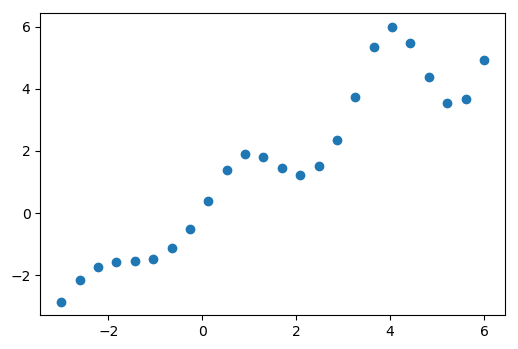

In [16]:
xleft = -3
xright = 6
n = 24
x = np.linspace(xleft,xright,n)
yf = np.zeros ((n))
y = np.zeros ((n))
for i in range(0,n):
    if (x[i]<0) :
        yf[i] = 1.0*x[i] + 0.5*np.sin(2*x[i])
    elif (x[i]<np.pi):
        yf[i] = 1.0*x[i] + 1.0*np.sin(2*x[i])
    else:
        yf[i] = 1.0*x[i] + 2.0*np.sin(2*x[i])
plt.plot (x,yf, 'o')

### Зашумление данных

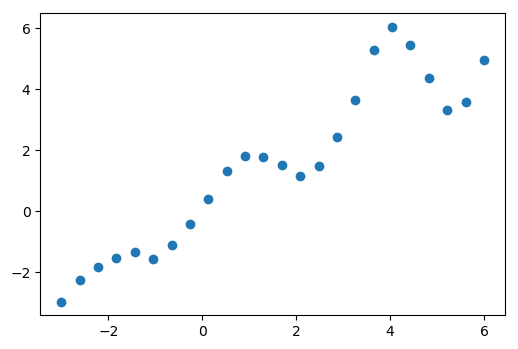

In [17]:
Delta = 0.1 * np.random.randn(len(x))
y = yf + Delta
plt.plot (x, y, 'o')

### Построение аппроксимационного полинома и оценка погрешности аппроксимации

Коэффициенты [ 1.67397411e-01  2.37142309e+00  6.62812437e-02 -9.12747492e-01
 -5.77844267e-02  1.71373546e-01  4.34381887e-03 -1.31964689e-02
  4.29059585e-04  3.86794173e-04 -3.63761898e-05]
Число обусловленности 6282860480363286.0 79261668.17435679
Максимальное и минимальное собственные значения G 5032160201183618.0 0.8009264243554169


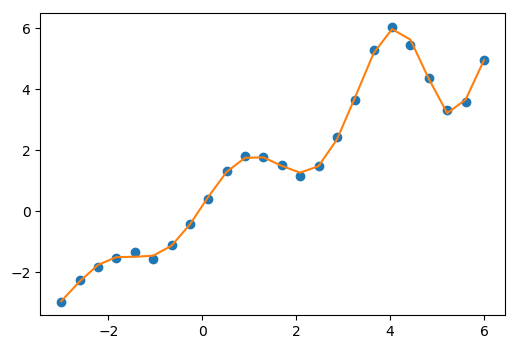

In [18]:
m = 10

PolynomCoefs = SqLeast (x, y, m)
print ('Коэффициенты', PolynomCoefs)

#print ('Gmatrix',G)
cond = np.linalg.cond (G)
condPhi = np.linalg.cond (Phi)
EigG = np.linalg.eigvals (G)
print ('Число обусловленности', cond, condPhi)
print ('Максимальное и минимальное собственные значения G', max (EigG), min (EigG))

PolynomValue = np.zeros(len(x))
for i in range (0, m+1):
    PolynomValue += PolynomCoefs[i]*x**i   

ResLocal, ResLocalRel, ResGlobal, ResGlobalRel = AppError (x,y,PolynomCoefs)

plt.plot (x, y, 'o')
plt.plot (x, PolynomValue)

### Оценка погрешности

Погрешность аппроксимации
Суммарная абсолютная, cуммарная относительная, коэффициент детерминации
0.0728639446844102 0.027544315237702635 0.9992413107956976
1.0000000000976115


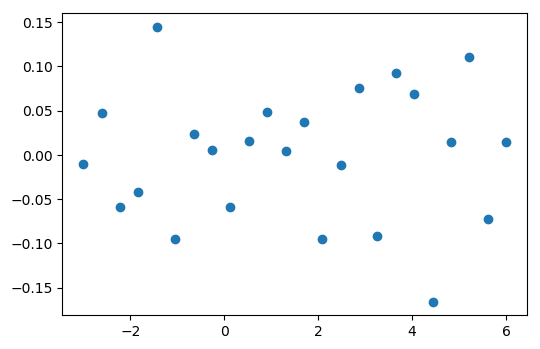

In [19]:
ResLocal, ResLocalRel, ResGlobal, ResGlobalRel = AppError (x,y,PolynomCoefs)
R2 = R2 (x,y,PolynomCoefs)
plt.plot (x, ResLocal, 'o')
print ('Погрешность аппроксимации')
print ('Суммарная абсолютная, cуммарная относительная, коэффициент детерминации')
print (ResGlobal, ResGlobalRel, R2)
print (ResGlobalRel**2+R2)

### Разделение данных на обучающий и тестовый наборы

[12 19  7 21  2 22]
0.058571087976503886 0.19420304120404355


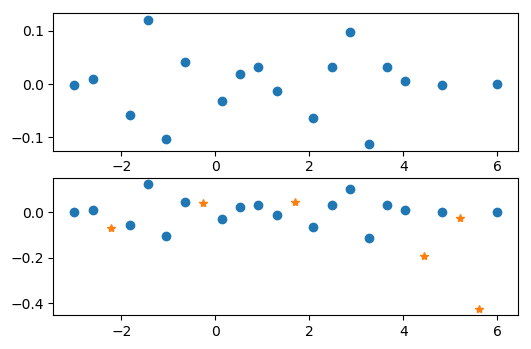

In [20]:
n = len(x)
ntest = int (n/4)
ntrain = n - ntest
xtrain = np.zeros (ntrain)
xtest = np.zeros (ntest)
ytrain = np.zeros (ntrain)
ytest = np.zeros (ntest)
#indtest = np.random.random_integers(0,n, ntest)
indtest = np.random.choice (len(x), ntest, replace = False)
print (indtest)

itest = -1
itrain = -1
for i in range (0,n):
    
    ktest = 0
    
    for k in range (0, ntest): 
        if (i==indtest[k]):
            itest += 1
            xtest [itest] = x[i]
            ytest [itest] = y[i]
            ktest = 1
            
    if (ktest !=1 ):
        itrain += 1
        xtrain [itrain] = x[i]
        ytrain [itrain] = y[i]
             
#print (xtest)
#print (xtrain)

PolynomCoefsTrain = SqLeast (xtrain, ytrain, m)
    
ResLocalTrain, ResLocalRelTrain, ResGlobalTrain, ResGlobalRelTrain = AppError (xtrain,ytrain,PolynomCoefsTrain)
ResLocalTest, ResLocalRelTest, ResGlobalTest, ResGlobalRelTest = AppError (xtest,ytest,PolynomCoefsTrain)    
    
print (ResGlobalTrain, ResGlobalTest)
 
plt.subplot (2,1,1)
plt.plot (xtrain, ResLocalTrain, 'o')
plt.subplot (2,1,2)
plt.plot (xtrain, ResLocalTrain, 'o')
plt.plot (xtest, ResLocalTest, '*')
#num_bins = 20
#plt.hist(ErrorLocalTrain, num_bins, density=1)

### Проблема обусловленности

In [21]:
n = 2
# Формирование матрицы Гильберта
MM = np.zeros ((n,n))
for i in range (0,n):
    for j in range (0,n):
        MM[i,j]=1/(i+j+1) #*10.
print (MM)
# Нахождение собственных значений матрицы
Evv = np.linalg.eigvals (MM)
print ('Eigen values', Evv)
# Формирование правой части
b = np.linspace (1,5,n)/n
print ('b',b)
# Нахождение решения системы уравнений
xx = np.linalg.solve(MM, b)
print ('solution',xx)
# Вычиление невязки
res = MM @ xx - b
print ('Residual', res)

MMinv = np.linalg.inv(MM)
normb = np.linalg.norm (b)
normM = np.linalg.norm (MM)
normMi = np.linalg.norm (MMinv)
normx = np.linalg.norm (xx)

#число обусловленности
cond = np.linalg.cond (MM)
print ('cond', cond, normM * normMi, max(Evv)/min(Evv))

#возмущение правой части
Del = (np.random.random(n)- 0.5) * 0.01
normDel = np.linalg.norm (Del)
b2 = b + Del
# Решение возмущенной системы
xx2 = np.linalg.solve(MM, b2)
print ('b', b2, )
print ('solution', xx2)
dx = xx-xx2
normdx = np.linalg.norm (dx)
res = MM @ xx2 - b2
print ('residual', res)

[[1.         0.5       ]
 [0.5        0.33333333]]
Eigen values [1.26759188 0.06574145]
b [0.5 2.5]
solution [-13.  27.]
Residual [0. 0.]
cond 19.28147006790397 19.333333333333336 19.281470067903967
b [0.50462662 2.49549726]
solution [-12.95447708  26.91820741]
residual [-2.22044605e-16  0.00000000e+00]


## Пример 3

Коэффициенты точные [-1.   1.   2.   1.  -1.  -0.5]
Коэффициенты МНК [-1.02434153  1.07477036  1.76678011  1.41183513 -1.32104219 -0.41603384]
12373162.973653337
Коэффициенты МНК с регуляризацией [-1.04024247  1.19291748  1.85267376  0.80563317 -0.78221025 -0.55235826]
369807.6341309839
s [6.17413874e+01 6.54357569e+00 2.56943786e+00 7.10994096e-01
 1.39866108e-01 1.75523802e-02]


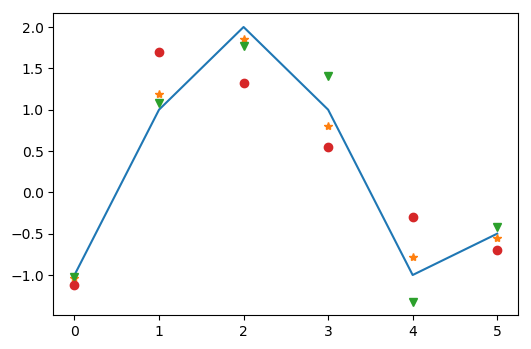

In [22]:
xleft = 0.0
xright = 2.0
n = 24
x = np.linspace(xleft,xright,n)
yf = np.zeros ((n))
y = np.zeros ((n))

coefs = np.array ([-1, 1, 2, 1,-1,-0.5])
m = len(coefs)- 1

print ('Коэффициенты точные', coefs)

for i in range (0, m+1):
    yf += coefs[i]*x**i
#plt.plot (x,yf, 'o')

Delta = 0.1 * np.random.randn(len(x))
y = yf + Delta
#plt.plot (x, y, '*')

PolynomCoefs = SqLeast (x, y, m)
print ('Коэффициенты МНК', PolynomCoefs)

#print ('Gmatrix',G)
cond = np.linalg.cond (G)
print (cond)

PolynomValue = np.zeros(len(x))
for i in range (0, m+1):
    PolynomValue += PolynomCoefs[i]*x**i
        
#plt.plot (x, y, 'o')
#plt.plot (x, PolynomValue)
#plt.subplot (x, ErrorLocal)

CoefsReg = SqLeastReg (x, y, m, 0.01)
print ('Коэффициенты МНК с регуляризацией', CoefsReg)
cond = np.linalg.cond (G)
print (cond)

PolynomValue = np.zeros(len(x))
for i in range (0, m+1):
    PolynomValue += CoefsReg[i]*x**i
#plt.plot (x, PolynomValue)

PhiInv = np.linalg.pinv(Phi, rcond = 1e-2)
CoefsSVD = PhiInv @ y
#print ('коэффициенты МНК SVD', CoefsSVD )

U, s, Vh = np.linalg.svd(Phi)
print ('s', s)
#smat = np.diag(s)

#plt.subplot (2,1,1)
plt.plot (coefs)
plt.plot (CoefsReg, '*')
plt.plot (PolynomCoefs, 'v')
plt.plot (CoefsSVD, 'o')
#plt.plot (coef2, '-')
#plt.subplot (2,1,2)
#plt.plot (coefs)
#plt.plot (coef2)